*이탤릭체 텍스트*

# MVtec Anormaly detection
### 과제 : VGG16, Resnet18 pretrained model활용
---






: 해당 파일은 Anomaly detection을 구현한 것으로 pretrained vgg16을 fine-tuning하여 모델을 생성하였다.


▪︎ drive mount

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


▪︎ module/data load

---


In [13]:
from sklearn.metrics import confusion_matrix

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets, utils
from torchsummary import summary
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# DEVICE 설정
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Parameter 설정
EPOCHS = 20
BATCH_SIZE = 64
LR = 0.0001

# Transform 설정
transform_MVtec = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# Dataset 설정
train_dataset = datasets.ImageFolder(root = '/content/drive/MyDrive/ sk 인공지능 과제/mvtec_anomaly_detection/bottle/train',
                                         transform = transform_MVtec)

train_size=len(train_dataset)*0.8
val_size = len(train_dataset)*0.2
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(train_size), int(val_size)])

test_dataset = datasets.ImageFolder(root = '/content/drive/MyDrive/ sk 인공지능 과제/mvtec_anomaly_detection/bottle/test',
                                transform = transform_MVtec)



train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True)


✲ 모델을 저장할 주소 입력


---



In [3]:
%cd /content/drive/MyDrive/ sk 인공지능 과제

/content/drive/MyDrive/ sk 인공지능 과제


▪︎ model load

---



In [4]:
from torchvision import models

# Pretrained VGG16 모델 로드
vgg_model = models.vgg16(pretrained=True).to(DEVICE)
vgg_model.classifier[6] = nn.Linear(in_features=4096, out_features=2).to(DEVICE)
print('Summary of vgg16')
summary(vgg_model, (3, 224, 224))
# # Pretrained ResNet 모델 로드
# res_model = models.resnet18(pretrained=True, num_classes=1000).to(DEVICE)
# res_model.fc = nn.Linear(res_model.fc.in_features,10).to(DEVICE)
# print('Summary of res18')
# summary(res_model, (3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 127MB/s]


Summary of vgg16
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14  

▪︎ Train

---

In [5]:
# Optimizer 설정
# res_optimizer = optim.Adam(res_model.parameters(), lr=LR)
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=LR)

In [6]:
train_accuracies_vgg, val_accuracies_vgg = [], []
train_losses_vgg, val_losses_vgg = [], []
# train_accuracies_resnet, val_accuracies_resnet = [], []
# train_losses_resnet, val_losses_resnet = [], []

# Train 구현
def train_one_epoch(model, train_loader, optimizer):
    model.train()
    correct = 0
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).sum().item()
    avg_loss = epoch_loss / len(train_loader)
    return avg_loss, 100. * correct / len(train_loader.dataset)

# early stopping 구현
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=True, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: True
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        # >> 과제2의 3)
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Evaluation 구현
def evaluate(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            # 배치 오차를 합산
            val_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

# vgg16
early_stopping = EarlyStopping(patience = 3,path='vgg_pre.pt')
print('==================== vgg fine-tuning ====================')
for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train_one_epoch(vgg_model, train_loader, vgg_optimizer)
    train_losses_vgg.append(train_loss)
    train_accuracies_vgg.append(train_accuracy)
    val_loss, val_accuracy = evaluate(vgg_model, val_loader)
    val_losses_vgg.append(val_loss)
    val_accuracies_vgg.append(val_accuracy)
    early_stopping(val_loss, vgg_model)
    print('[{}] Train Accuracy: {:.2f}%, Train Loss: {:.6f}\n    Validation Accuracy: {:.2f}%, Validation Loss: {:.6f}'.format(
          epoch, train_accuracy, train_loss, val_accuracy, val_loss))
    if early_stopping.early_stop:
        break

# # resnet18
# print('==================== resnet fine-tuning ====================')
# early_stopping = EarlyStopping(patience = 3,path='resnet_pre.pt')
# for epoch in range(1, EPOCHS + 1):
#     train_loss, train_accuracy = train_one_epoch(res_model, train_loader, res_optimizer)
#     train_losses_resnet.append(train_loss)
#     train_accuracies_resnet.append(train_accuracy)
#     val_loss, val_accuracy = evaluate(res_model, val_loader)
#     val_losses_resnet.append(val_loss)
#     val_accuracies_resnet.append(val_accuracy)
#     early_stopping(val_loss, res_model)
#     print('[{}] Train Accuracy: {:.2f}%, Train Loss: {:.6f}\n     Validation Accuracy: {:.2f}%, Validation Loss: {:.6f}'.format(
#           epoch, train_accuracy, train_loss, val_accuracy, val_loss))
#     if early_stopping.early_stop:
#         break


==================== vgg fine-tuning ====================
Validation loss decreased (inf --> 0.116579).  Saving model ...
[1] Train Accuracy: 72.73%, Train Loss: 0.402723
    Validation Accuracy: 97.73%, Validation Loss: 0.116579
EarlyStopping counter: 1 out of 3
[2] Train Accuracy: 94.32%, Train Loss: 0.233773
    Validation Accuracy: 97.73%, Validation Loss: 0.174913
Validation loss decreased (0.116579 --> 0.033716).  Saving model ...
[3] Train Accuracy: 94.32%, Train Loss: 0.168152
    Validation Accuracy: 97.73%, Validation Loss: 0.033716
Validation loss decreased (0.033716 --> 0.014305).  Saving model ...
[4] Train Accuracy: 95.45%, Train Loss: 0.084174
    Validation Accuracy: 100.00%, Validation Loss: 0.014305
Validation loss decreased (0.014305 --> 0.000762).  Saving model ...
[5] Train Accuracy: 100.00%, Train Loss: 0.029677
    Validation Accuracy: 100.00%, Validation Loss: 0.000762
Validation loss decreased (0.000762 --> 0.000074).  Saving model ...
[6] Train Accuracy: 100.0

▪︎ Visualization

---



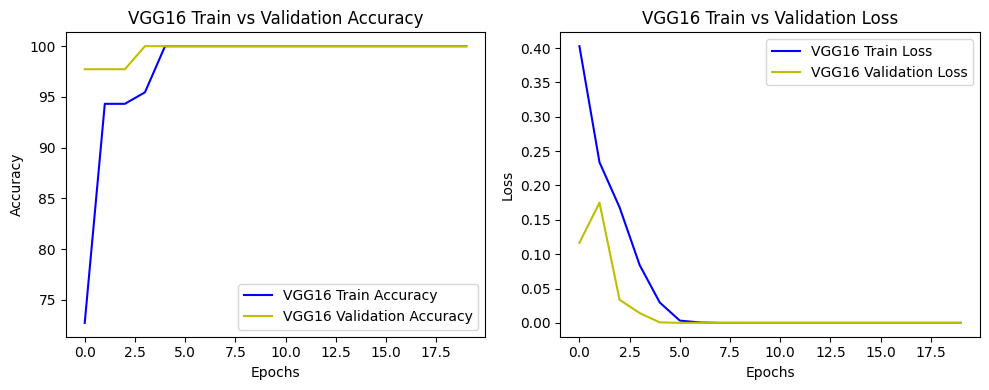

In [8]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(10, 4))

# VGG_Accuracy
axs[0].plot(train_accuracies_vgg, color='b', label='VGG16 Train Accuracy')
axs[0].plot(val_accuracies_vgg, color='y', label='VGG16 Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].set_title('VGG16 Train vs Validation Accuracy')

# VGG_Loss
axs[1].plot(train_losses_vgg, color='b', label='VGG16 Train Loss')
axs[1].plot(val_losses_vgg, color='y', label='VGG16 Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].set_title('VGG16 Train vs Validation Loss')

# # ResNet
# axs[1][0].plot(train_accuracies_resnet, color='b', label='ResNet18 Train Accuracy')
# axs[1][0].plot(val_accuracies_resnet, color='y', label='ResNet18 Validation Accuracy')
# axs[1][0].set_xlabel('Epochs')
# axs[1][0].set_ylabel('Accuracy')
# axs[1][0].legend()
# axs[1][0].set_title('ResNet18 Train vs Validation Accuracy')

# # ResNet
# axs[1][1].plot(train_losses_resnet, color='b', label='ResNet18 Train Loss')
# axs[1][1].plot(val_losses_resnet, color='y', label='ResNet18 Validation Loss')
# axs[1][1].set_xlabel('Epochs')
# axs[1][1].set_ylabel('Loss')
# axs[1][1].legend()
# axs[1][1].set_title('ResNet18 Train vs Validation Loss')

plt.tight_layout()
plt.show()


▪︎ Test result Visualization

---

- testset의 labeling과 model의 예측 결과가 같을 때 right 출력, 배경색을 파란색으로 표기
- testset의 labeling과 model의 예측 결과가 다를 때 wrong 출력, 배경색을 빨간색으로 표기


In [9]:
CLASSES = dict()
for i in range(2) :
    CLASSES[i] = test_dataset.classes[i]
print(CLASSES)

{0: 'broken_large', 1: 'good'}


In [31]:
y_pred=[]
y_true=[]
for i in range(1,len(test_dataset)):
    input_img = test_dataset[i][0].unsqueeze(dim=0).to(DEVICE)

    output = vgg_model(input_img)
    _, argmax = torch.max(output, 1)
    y_pred.append(argmax.item())
    y_true.append(test_dataset[i][1])

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[ 8  0]
 [ 0 20]]


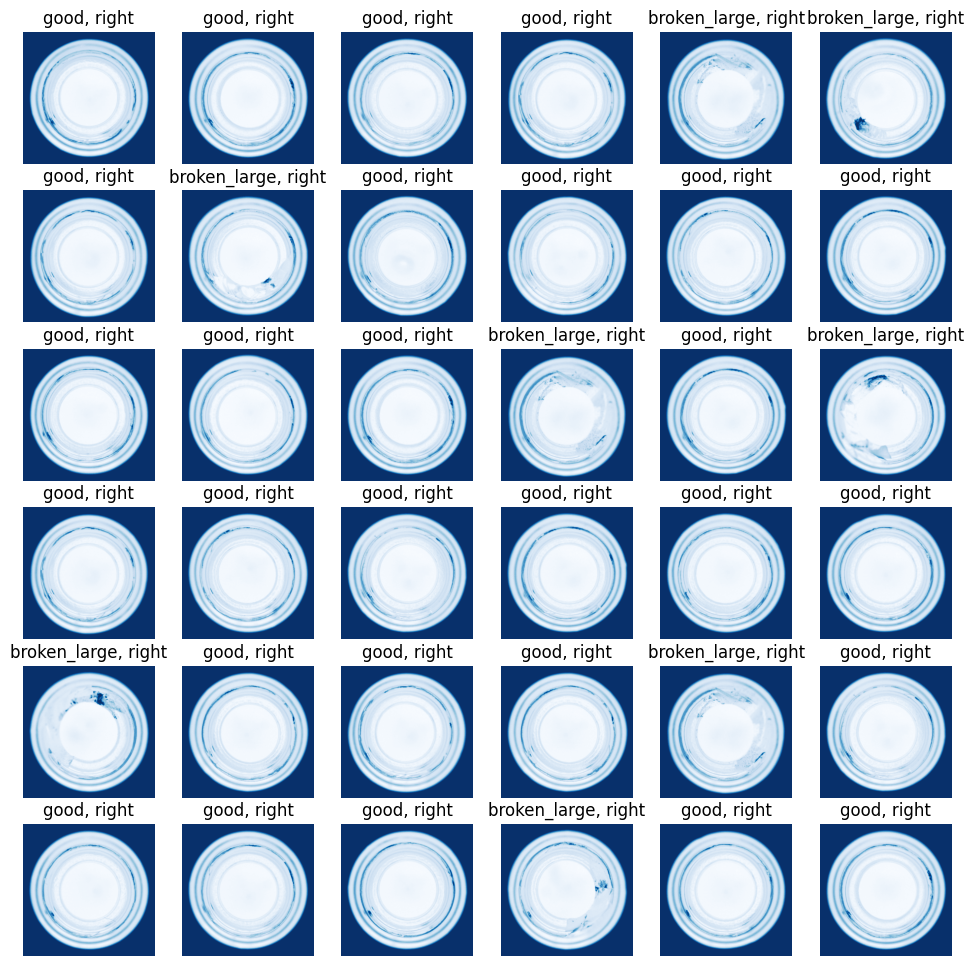

In [11]:
# Visualization
columns = 6
rows = 6
fig = plt.figure(figsize=(12,12))

vgg_model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(DEVICE)

    output = vgg_model(input_img)
    _, argmax = torch.max(output, 1)
    pred = CLASSES[argmax.item()]
    label = CLASSES[test_dataset[data_idx][1]]

    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + ', right')
        cmap = 'Blues'
    else:
        plt.title('N ' + pred + ' B ' +  label)
        cmap = 'Reds'
    plot_img = test_dataset[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.show()